# Day Ahead Market Gas Price Predictions

**The Day-Ahead Market** is a type of short-term energy market where  commodities such as gas or electricity are traded for delivery on the following day. It is a crucial component of the energy market structure, allowing for the efficient scheduling and balancing of supply and demand.

In the **natural gas** market, the Day-Ahead Market allows participants to trade gas for next-day delivery. This market helps ensure that gas supply matches demand, thereby optimizing the use of infrastructure and managing the flow of gas through the pipeline network.

# Import libraries

Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys

from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers import Bidirectional
from keras.layers import LSTM
import warnings

from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from tensorflow.keras.layers  import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from sklearn.metrics import mean_squared_error

import pmdarima as pm
import os
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

# I.Exploratory Data Analysis

**Exploratory Data Analysis** is the 1st step in the data analysis process, providing foundational understanding needed to inform subsequent steps.By employing a variety techniques(Descriptive Statistics,Data Visualization,Dimensionality Reduction), **EDA** helps uncover the underlying patterns and insights within the dataset, understand Data Structure and contribute in taking Modeling Decisions.

Structure of the Dataset

**FWD Price Day-Ahead Gas**

*   Period : 01.05.2022-30.04.2024
*   Frequecy : Daily
*   Unit : LEI/MWh

Columns:
*   Data : Date of the trading day (index)
*   FWD : Price of gas  






In [2]:
#read data
df=pd.read_excel("C:\\Users\\user\\Desktop\\STAT ANUL I\\SEM 2\\ECON AVANSATA\\sem_python\\proiect\\fwd_price.xlsx")
df.head(1500)

,Data,FWD
0,2022-05-01,NaN
1,2022-05-02,350.935242
2,2022-05-03,338.935242
3,2022-05-04,349.251782
4,2022-05-05,373.251782
...,...,...
726,2024-04-26,127.420464
727,2024-04-27,NaN
728,2024-04-28,NaN
729,2024-04-29,117.073024


https://github.com/alexdr20/FWD-Price-Day-Ahead-Gas-/blob/main/fwd_price.xlsx

In [3]:
#descriptive statistics
df.describe()

,FWD
count,497.000000
mean,324.654077
std,160.810221
min,115.944254
25%,217.293317
50%,281.653201
75%,410.463838
max,949.314193


In [4]:
#set index data
df=df.set_index('Data')

In [5]:
#print indexed df
print(df)
print(len(df))

                   FWD
Data                  
2022-05-01         NaN
2022-05-02  350.935242
2022-05-03  338.935242
2022-05-04  349.251782
2022-05-05  373.251782
...                ...
2024-04-26  127.420464
2024-04-27         NaN
2024-04-28         NaN
2024-04-29  117.073024
2024-04-30  122.384668

[731 rows x 1 columns]
731


In [6]:
#drop NaN values
df.dropna(inplace=True)
df

,FWD
Data,
2022-05-02,350.935242
2022-05-03,338.935242
2022-05-04,349.251782
2022-05-05,373.251782
2022-05-06,389.251782
...,...
2024-04-24,127.000000
2024-04-25,127.559830
2024-04-26,127.420464


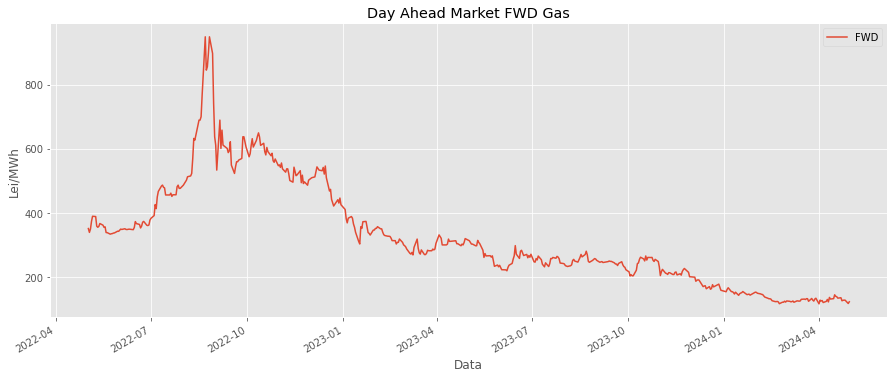

In [7]:
#line plot time series
df.plot(figsize=(15, 6),label = 'FWD Gas Price')
plt.xlabel("Data")
plt.ylabel('Lei/MWh')
plt.title("Day Ahead Market FWD Gas")
plt.legend()
plt.show()

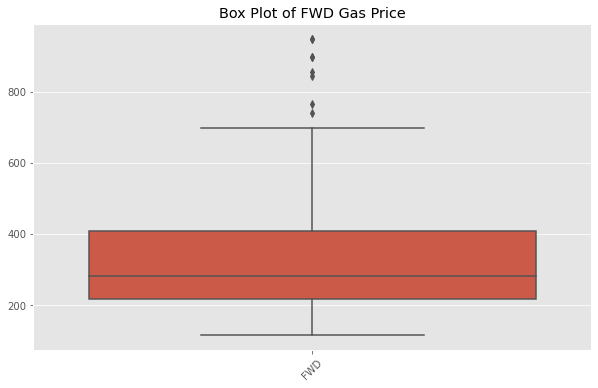

In [8]:
#box plot time series
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title('Box Plot of FWD Gas Price')
plt.show()

In [9]:
#check for outliars IQR Method
#  Q1 (25th perc) and Q3 (75th perc)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = df[(df < lower_bound) | (df > upper_bound)].dropna(axis=0)

print(outliers)

                   FWD
Data                  
2022-08-19  767.314193
2022-08-22  949.314193
2022-08-23  845.314193
2022-08-24  855.714193
2022-08-25  897.314193
2022-08-26  949.314193
2022-08-29  897.314193
2022-08-30  741.314193


In [10]:
#remove outliers from df
df=df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
df

,FWD
Data,
2022-05-02,350.935242
2022-05-03,338.935242
2022-05-04,349.251782
2022-05-05,373.251782
2022-05-06,389.251782
...,...
2024-04-24,127.000000
2024-04-25,127.559830
2024-04-26,127.420464


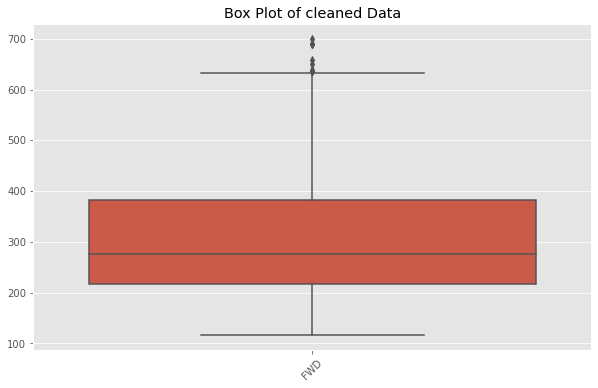

In [11]:
#box plot cleaned df
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title('Box Plot of cleaned Data')
plt.show()

We still observe extreme values ~600 lei/MWh. Hopefully, they will not influence the further analysis.

# II.Time Series Statistical Analysis

**Time Series Statistical Analysis** involves examining and interpreting data points collected or recorded at specific time intervals. The process helps to understand underlying patterns, trends, seasonality, and potential future behavior of the data.
**TSSA**  is the preliminary process in prediction future values accurately for the dataset in the study case.


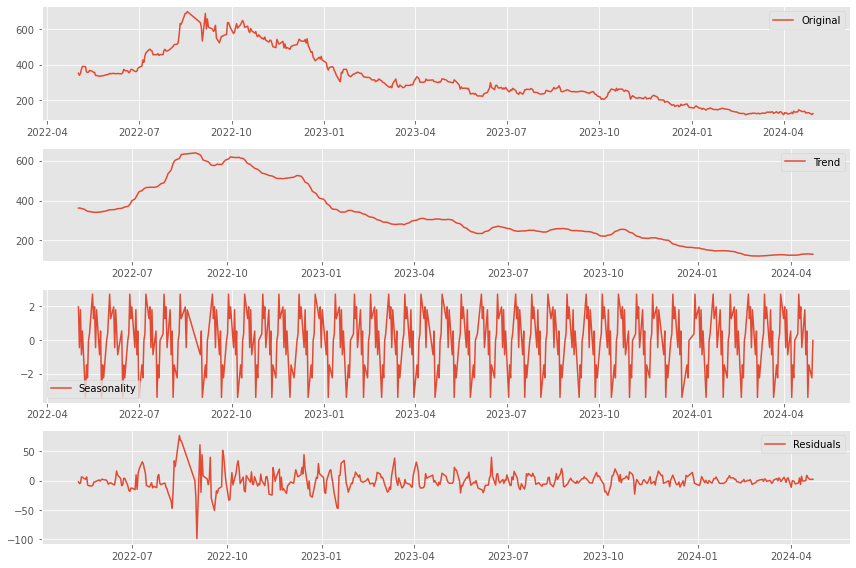

In [12]:
#visualization plots
decomposition = seasonal_decompose(df,period=12)
rcParams['figure.figsize'] = 12, 8

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [13]:
#check stationarity
def test_stationarity(timeseries):
    rcParams['figure.figsize'] = 10, 6
    rolmean = timeseries.rolling(12).mean() #allows you to calculate moving avg
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('p-value=', dftest[1])


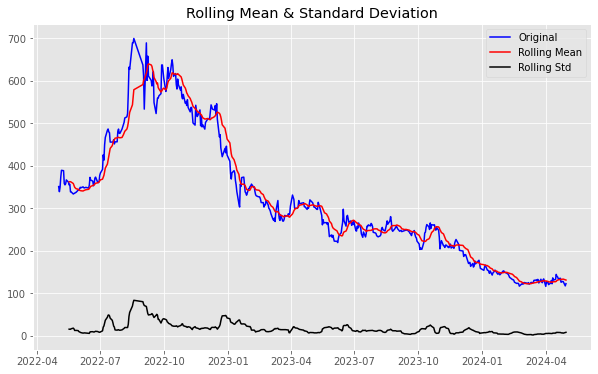

Results of Dickey-Fuller Test:
p-value= 0.8793958707391852


In [14]:
#check ADF test
test_stationarity(df)

In [15]:
#first-order differencing series
df_dif = df.diff()

#drop NaN values
df_dif = df_dif.dropna()
df_dif

,FWD
Data,
2022-05-03,-12.000000
2022-05-04,10.316540
2022-05-05,24.000000
2022-05-06,16.000000
2022-05-09,-0.898007
...,...
2024-04-24,1.431115
2024-04-25,0.559830
2024-04-26,-0.139366


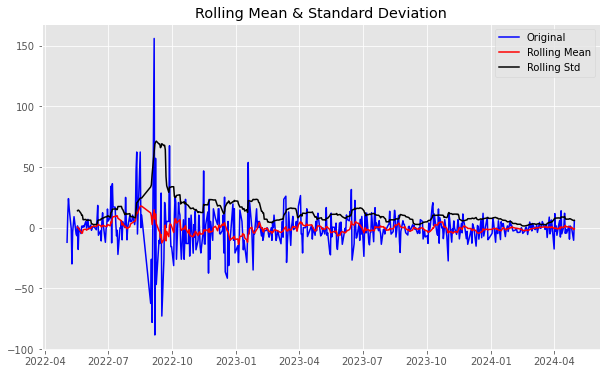

Results of Dickey-Fuller Test:
p-value= 1.0746283428399702e-26


In [16]:
#ADF test 1st diff series
test_stationarity(df_dif)

# III.Cross Validation

**Data Cross-Validation** is a technique used to evaluate the performance and robustness of a predictive model by partitioning the original dataset into training and testing subsets multiple times. The goal is to ensure the model generalizes well to unseen data.

In [59]:
#split train - test set
train_size=int(len(df)*0.8)
trainset, testset=df[0:train_size], df[train_size:]

In [60]:
#length of train set
trainset.head(500)

,FWD
Data,
2022-05-02,350.935242
2022-05-03,338.935242
2022-05-04,349.251782
2022-05-05,373.251782
2022-05-06,389.251782
...,...
2023-11-29,200.665642
2023-12-04,199.143139
2023-12-05,186.425448


In [61]:
#length of test set
testset.head(500)

,FWD
Data,
2023-12-08,190.291479
2023-12-11,175.110072
2023-12-12,169.740301
2023-12-13,171.569970
2023-12-14,172.479241
...,...
2024-04-24,127.000000
2024-04-25,127.559830
2024-04-26,127.420464


In [62]:
#train - test set for 1st order diff series
trainD_size=int(len(df_dif)*0.8)
trainDset, testDset=df_dif[0:trainD_size], df_dif[trainD_size:]

In [63]:
testDset.head(500)

,FWD
Data,
2023-12-08,-0.513743
2023-12-11,-15.181406
2023-12-12,-5.369772
2023-12-13,1.829669
2023-12-14,0.909271
...,...
2024-04-24,1.431115
2024-04-25,0.559830
2024-04-26,-0.139366


In [64]:
#performance check function
def performance(y_true, y_pred):
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

# IV.Model Forecasting

In general, the **model forecasting process** involves predicting future values based on historical data using statistical or machine learning models.
For this particular dataset, in this study I have chosen 3 different statistical modelling techniques:

*   Auto Regressive Moving Average (ARIMA/SARIMA)
*   Long Short-Term Memory (LSTM)
*   Convolutional Neural Networks (CNN)

In the end, the best model which fit will be chosen by comparing the performance of the models using the metrics defined:

*   Mean Squared Error (MSE)
*   Root Mean Squared Error (RMSE)
*   Mean Absolute Percentage Error (MAPE)



# 1.ARIMA/SARIMA

**ARIMA** (AutoRegressive Integrated Moving Average) is a popular time series forecasting method that combines three components: autoregression (AR), differencing (I), and moving average (MA). It is widely used for modeling and forecasting time series data with stationary or near-stationary behavior.

Model Representation:ARIMA(p,d,q)
* p: Order of the autoregressive component.
* d: Degree of differencing required to achieve stationarity.
* q: Order of the moving average component.

SARIMA models include additional seasonal AR, I, and MA components in addition to the non-seasonal components present in ARIMA.

In [23]:
# use AUTO Arima to find optimal lag
model_FWD = pm.auto_arima(testDset,seasonal=True, m=4,d=1,
                       trace=True,error_action='ignore',suppress_warnings=True)

#summary model optim
print(model_FWD.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=712.187, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=665.037, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=710.191, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=664.516, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=663.780, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=664.724, Time=0.08 sec
 ARIMA(1,1,0)(0,0,2)[4] intercept   : AIC=663.027, Time=0.10 sec
 ARIMA(1,1,0)(1,0,2)[4] intercept   : AIC=664.244, Time=0.14 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=712.879, Time=0.07 sec
 ARIMA(2,1,0)(0,0,2)[4] intercept   : AIC=636.933, Time=0.12 sec
 ARIMA(2,1,0)(0,0,1)[4] intercept   : AIC=637.304, Time=0.06 sec
 ARIMA(2,1,0)(1,0,2)[4] intercept   : AIC=638.849, Time=0.17 sec
 ARIMA(2,1,0)(1,0,1)[4] intercept   : AIC=638.414, Time

In [24]:
#fitting model
sarima_model_FWD = sm.tsa.statespace.SARIMAX(testset,
                                order=(2, 1, 1),
                                seasonal_order=(0, 0, 0, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_FWD= sarima_model_FWD.fit()
print(sarima_fit_FWD.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4574      0.539     -0.849      0.396      -1.513       0.598
ar.L2         -0.1472      0.212     -0.696      0.486      -0.562       0.267
ma.L1          0.0262      0.554      0.047      0.962      -1.059       1.112
sigma2        25.6422      3.627      7.070      0.000      18.534      32.751


c:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


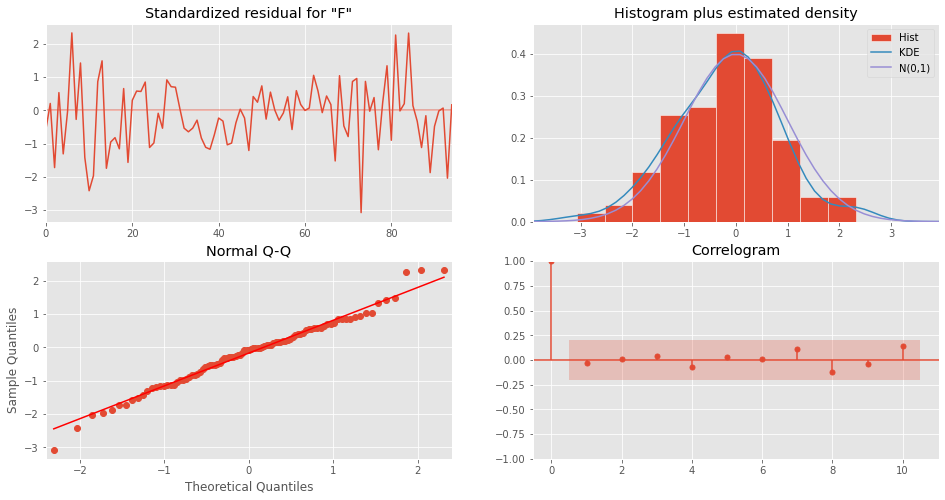

In [25]:
#plot SARIMA model diagnostics
sarima_fit_FWD.plot_diagnostics(figsize=(16, 8))
plt.show()

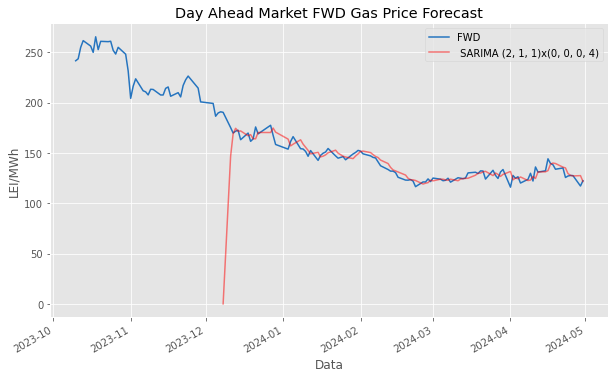

In [26]:
# One step ahead forecast
sarima_predict_FWD = sarima_fit_FWD.get_prediction()
sarima_predict_conf_FWD = sarima_predict_FWD.conf_int()

#observed plot
ax = df[350:].plot(label='Initial',color='#2574BF')

#predicted plot
rcParams['figure.figsize'] = 14, 4
sarima_predict_FWD.predicted_mean.plot(ax=ax, label=' SARIMA (2, 1, 1)x(0, 0, 0, 4)', alpha= 0.5, color='red')
plt.title('Day Ahead Market FWD Gas Price Forecast')
plt.xlabel('Data')
plt.ylabel('LEI/MWh')
plt.legend()
plt.show()


In [27]:
#check ARIMA model performance
sarima=performance(df["FWD"],sarima_predict_FWD.predicted_mean)
sarima

{'MSE': 402.56, 'RMSE': 20.06, 'MAPE': 3.89}

# 2.LSTM

**Long Short-Term Memory** (LSTM) is a type of **recurrent neural network** (RNN) architecture designed to model sequential data and capture long-term dependencies. It is particularly effective for time series forecasting tasks due to its ability to remember information over long periods and handle temporal patterns effectively.

When properly configured and trained, LSTM models can provide accurate and reliable predictions for a wide range of forecasting problems.


In [28]:
trainset.shape

(391, 1)

In [29]:
testset.shape

(98, 1)

In [30]:
#scalling data
scaler = MinMaxScaler()
scaler.fit(trainset)
train = scaler.transform(trainset)
test = scaler.transform(testset)

In [31]:
#no of obs to be predicted (testset)
n_input = 98
#univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

In [32]:
#define model
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(391, activation='relu'), input_shape=(98, 1)))
model_bi.add(Dense(1))
model_bi.compile(optimizer='adam', loss='mse')

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
#generate model
model_bi.fit(generator,epochs=25)

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - loss: 0.0029
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - loss: 0.0060
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - loss: 0.0022
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - loss: 0.0038
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - loss: 0.0015
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - loss: 0.0019
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - loss: 0.0036
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - loss: 0.0012
Epoch 9/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - loss: 0.0016
Epoch 10/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - loss: 0.0017
Epoch 11/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - loss: 0.0018
Epoch 12/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - loss: 0.0018
Epoch 13/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - loss: 0.0012
Epoch 14/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.0019
Epoch 15/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - lo

In [53]:
#predict values
pred_list_b = []
batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list_b.append(model_bi.predict(batch)[0])
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1)

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_b),
                          index=df[-n_input:].index, columns=['LSTM Prediction'])
df_predict_bi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

,LSTM Prediction
Data,
2023-12-08,141.741922
2023-12-11,143.143144
2023-12-12,144.951019
2023-12-13,146.925726
2023-12-14,149.131041
...,...
2024-04-24,182.169725
2024-04-25,181.454706
2024-04-26,180.751695


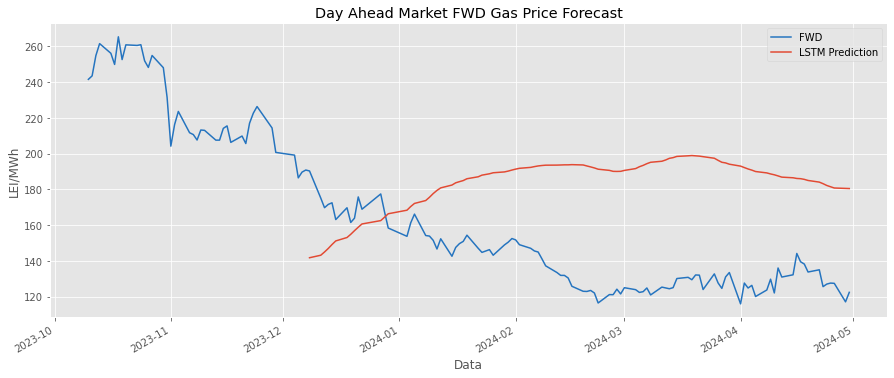

In [54]:
#predicted plot
ax = df[350:].plot(label='Initial',color='#2574BF')
df_predict_bi.plot(ax=ax,figsize=(15, 6),label = 'FWD Gas Price')
rcParams['figure.figsize'] = 14, 4
plt.title('Day Ahead Market FWD Gas Price Forecast')
plt.xlabel('Data')
plt.ylabel('LEI/MWh')
plt.legend()
plt.show()

In [55]:
#check model performance
bi_lstm= performance(df[-98:]['FWD'],df_predict_bi['LSTM Prediction'])
bi_lstm_predict=df_predict_bi['LSTM Prediction']
bi_lstm

{'MSE': 2889.48, 'RMSE': 53.75, 'MAPE': 37.66}

# 3.CNN

**Convolutional Neural Networks** (CNNs) are a class of deep neural networks primarily used for analyzing visual imagery, but they have also been successfully applied to various other types of data, including time series data.
Using Convolutional Neural Networks (CNNs) for stock price prediction involves treating the historical stock price data as a sequential input and leveraging the CNN architecture to extract relevant temporal patterns.

Model Architecture:
* **1D Convolutional Layers**: Configure one-dimensional convolutional layers to process the sequential input data.

* **Pooling Layers**: Optionally include pooling layers (e.g., max pooling) to downsample the feature maps and reduce dimensionality.

* **Flatten Layer**: Flatten the output from the convolutional layers into a one-dimensional vector to feed into the subsequent fully connected layers.

* **Fully Connected Layers**: Add fully connected layers to learn high-level representations and make predictions.

* **Output Layer**: Depending on the task (classification or regression), include an appropriate output layer with suitable activation function .

In [37]:
#check shape of df
df.shape

(489, 1)

In [38]:
#define cnn df
dfcnn=np.array(df)
dfcnn= dfcnn.reshape(-1,1)

In [39]:
#scale data
scaler = MinMaxScaler()
ts = scaler.fit_transform(dfcnn)

In [40]:
#set the timestep
timestep = 4
X= []
Y=[]
raw_data=ts
for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])
X=np.asanyarray(X)
Y=np.asanyarray(Y)

In [41]:
#Set the train - test set
X_train = X[:387,:,:]
Y_train = Y[:387]
X_test = X[387:,:,:]
Y_test= Y[387:]

In [42]:
# Reshape data for CNN input (assuming you have time series data)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [43]:
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer for regression
])

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [45]:
model_nn=model.fit(X_train_cnn, Y_train, epochs=20, validation_data=(X_test_cnn, Y_test))

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1462 - mae: 0.3306 - val_loss: 0.0032 - val_mae: 0.0541
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0295 - mae: 0.1251 - val_loss: 0.0228 - val_mae: 0.1506
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - mae: 0.0842 - val_loss: 0.0215 - val_mae: 0.1463
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - mae: 0.0688 - val_loss: 0.0117 - val_mae: 0.1075
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - mae: 0.0558 - val_loss: 0.0109 - val_mae: 0.1038
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - mae: 0.0487 - val_loss: 0.0086 - val_mae: 0.0919
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0440 - val_loss: 0.0055 - val_mae: 0.0733
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0367 - val_loss: 0.0039 - val_mae: 0.0616
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae:

In [46]:
#CNN model predicted dataset
predictions = model.predict(X_test_cnn)
pred_cnn=scaler.inverse_transform(predictions)
cnn_pred=pd.DataFrame(pred_cnn)
index=testset.index.to_numpy()
cnn_pred=pd.DataFrame(pred_cnn,index=index,columns=["FWD Pred"])
cnn_pred

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


,FWD Pred
2023-12-08,193.198029
2023-12-11,191.433838
2023-12-12,191.300018
2023-12-13,186.109024
2023-12-14,179.821136
...,...
2024-04-24,146.396790
2024-04-25,143.734818
2024-04-26,142.101135
2024-04-29,140.609573


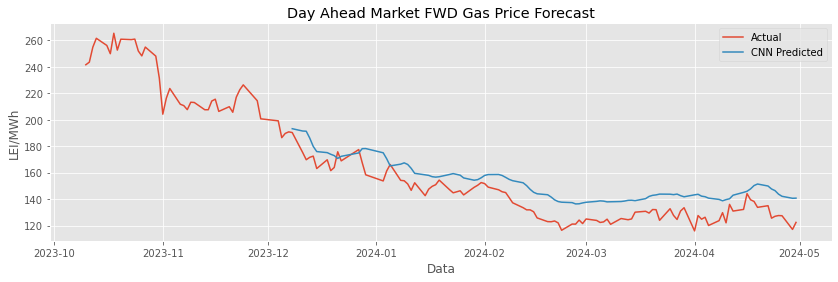

In [47]:
# Plot actual vs. predicted prices
plt.plot(df[350:],label='Actual')
plt.plot(cnn_pred, label='CNN Predicted')
plt.xlabel('Data')
plt.ylabel('LEI/MWh')
plt.title('Day Ahead Market FWD Gas Price Forecast')
plt.legend()

In [48]:
#check model performance
cnn= performance(Y_test,pred_cnn)
cnn

C:\Users\user\AppData\Local\Temp\ipykernel_14596\2223896279.py:4: RuntimeWarning: divide by zero encountered in divide
  mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'MSE': 23400.27, 'RMSE': 152.97, 'MAPE': inf}

# V.Conclusion

In this section, I am going to conclude the results of the three different modelling techniques, based on different criteria:

*   values predicted
*   metrics performance
*   plot of predictions



In [56]:
#evaluate all 3 models performance
prediction_data = {'Model':['SARIMA DIF','Bidirectional LSTM','CNN'],

                    'MSE':[sarima['MSE'],
                           bi_lstm['MSE'],cnn['MSE']],
                  'RMSE':[sarima['RMSE'],
                        bi_lstm['RMSE'],cnn['RMSE']],
                  'MAPE':[sarima['MAPE'],
                          bi_lstm['MAPE'],cnn['MAPE']]}

prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Model,MSE,RMSE,MAPE
0,SARIMA DIF,402.56,20.06,3.89
1,Bidirectional LSTM,2889.48,53.75,37.66
2,CNN,23400.27,152.97,inf


Judging on the performance metrics results, SARIMA Dif model seems to fit best, regarding MSE and RMSE values.

On the other hand, the CNN model seems to fit better on the MAPE performance, egarding the values predicted.

The Bidirectional LSTM model would better fit on a less volatile time-series. We could observe the sensitivity of the model for outliars and estreme-values.

In [57]:
#compare predicted values for 3 models
prediction_data = {
       'Test Set':df[-98:]["FWD"],
        'SARIMA DIF':sarima_predict_FWD.predicted_mean,
        'Bidirectional LSTM':df_predict_bi['LSTM Prediction'],
        'CNN': cnn_pred['FWD Pred']}

prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Test Set,SARIMA DIF,Bidirectional LSTM,CNN
2023-12-08,190.291479,0.000000,141.741922,193.198029
2023-12-11,175.110072,146.767424,143.143144,191.433838
2023-12-12,169.740301,168.908823,144.951019,191.300018
2023-12-13,171.569970,174.432178,146.925726,186.109024
2023-12-14,172.479241,171.448859,149.131041,179.821136
...,...,...,...,...
2024-04-24,127.000000,129.451567,182.169725,146.396790
2024-04-25,127.559830,127.669924,181.454706,143.734818
2024-04-26,127.420464,127.090128,180.751695,142.101135
2024-04-29,117.073024,127.410424,180.527100,140.609573


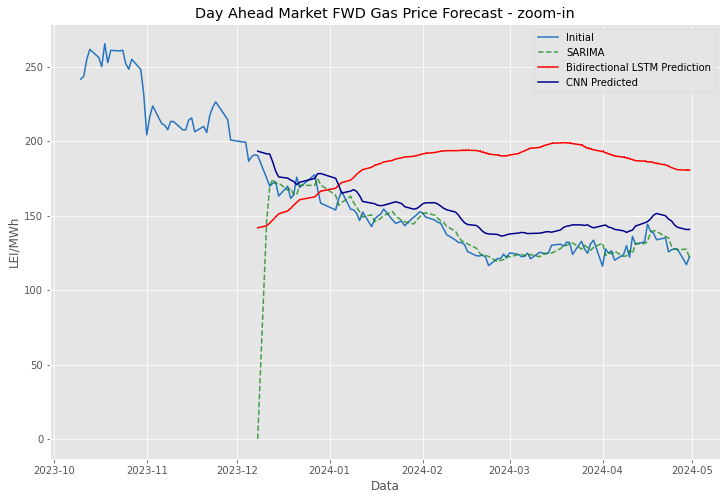

In [58]:
# line plot of observed vs predicted for all 3 models
rcParams['figure.figsize'] = 12, 8
plt.plot(df[350:],label="Initial",color='#2574BF')

#SARIMA
plt.plot(sarima_predict_FWD.predicted_mean, label='SARIMA', alpha= 0.7,linestyle= "--", color='g')

#Bidirectional LSTM
plt.plot(df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')

#CNN
plt.plot(cnn_pred, label='CNN Predicted',color='darkblue')

plt.xlabel('Data')
plt.ylabel('LEI/MWh')
plt.legend()
plt.title('Day Ahead Market FWD Gas Price Forecast - zoom-in')
plt.show()

On the vizualization of the prediction, we could clearly conclude the statements above:


*   SARIMA model fits best as it can adapt and adjust to seasonal changes and shocks ;
*   CNN model follows the trend of the future set, but not close enough ;
*   LSTM model does not fit into the shocks and into the volatile changes on the market ;



